# iPython Notebooks Used for this Analysis

http://nbviewer.ipython.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb
http://blog.yhathq.com/posts/logistic-regression-and-python.html
http://statsmodels.sourceforge.net/0.5.0/example_formulas.html
http://nbviewer.ipython.org/github/carljv/Will_it_Python/blob/master/MLFH/CH2/ch2.ipynb
http://nbviewer.ipython.org/github/carljv/Will_it_Python/blob/master/ARM/ch5/arsenic_wells_switching.ipynb
http://nbviewer.ipython.org/urls/s3.amazonaws.com/datarobotblog/notebooks/multiple_regression_in_python.ipynb
http://nbviewer.ipython.org/urls/s3.amazonaws.com/datarobotblog/notebooks/ordinary_least_squares_in_python.ipynb

# Load Libraries

In [1]:
#Import libraries
import sys
import pandas as pd
import pandas.io.sql as pdsql
import pyodbc
import matplotlib.pyplot as plt
from   IPython.display import HTML
import folium
import pymssql
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from pandas import DataFrame
from patsy import dmatrices
from statsmodels.discrete.discrete_model import Logit

# Set iPython to display visualization inline
%matplotlib inline

In [2]:
#Print python and pandas version
print 'Python version ' + sys.version
print 'Pandas version: ' + pd.__version__

Python version 2.7.9 |Anaconda 2.1.0 (x86_64)| (default, Dec 15 2014, 10:37:34) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Pandas version: 0.14.1


# Load Training Data

In [3]:
#For Mac OS
Location1 = r'/Users/viral.parikh/Desktop/External_Datasets/kaggle/titanic/train.csv'
training_data = pd.read_csv(Location1)

print training_data.head()
print training_data.info()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<class '

In [4]:
#survival       Survival, (0 = No; 1 = Yes)
#pclass          Passenger Class, (1 = 1st; 2 = 2nd; 3 = 3rd)
#sex             Sex
#age             Age
#sibsp           Number of Siblings/Spouses Aboard
#parch           Number of Parents/Children Aboard
#ticket          Ticket Number
#fare            Passenger Fare
#cabin           Cabin
#embarked        Port of Embarkation, (C = Cherbourg; Q = Queenstown; S = Southampton)

#feature - cabin has only 204 values, rest are missing. hence for now we will exclude all NA values
#remove variables - passengerid, name, ticket, cabin

In [4]:
training_data.groupby('Survived')['PassengerId'].count()

Survived
0           549
1           342
Name: PassengerId, dtype: int64

In [6]:
# 342 survived, 549 did not survive
# survival rate = 342/891 = 38%

In [22]:
# Remove certain columns
df_titanic = training_data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

# Remove NaN values
df_titanic1 = df_titanic.dropna()

df_titanic1.info()
df_titanic1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 8 columns):
Survived    712 non-null int64
Pclass      712 non-null int64
Sex         712 non-null object
Age         712 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    712 non-null object
dtypes: float64(2), int64(4), object(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22,1,0,7.2500,S
1,1,1,female,38,1,0,71.2833,C
2,1,3,female,26,0,0,7.9250,S
3,1,1,female,35,1,0,53.1000,S
4,0,3,male,35,0,0,8.0500,S


In [7]:
# summarize the data
print df_titanic1.describe()

         Survived      Pclass         Age       SibSp       Parch        Fare
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000
mean     0.404494    2.240169   29.642093    0.514045    0.432584   34.567251
std      0.491139    0.836854   14.492933    0.930692    0.854181   52.938648
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    1.000000   20.000000    0.000000    0.000000    8.050000
50%      0.000000    2.000000   28.000000    0.000000    0.000000   15.645850
75%      1.000000    3.000000   38.000000    1.000000    1.000000   33.000000
max      1.000000    3.000000   80.000000    5.000000    6.000000  512.329200


In [23]:
df_titanic1['Age_Group']=pd.cut(df_titanic1.Age, [0,10,20,30,40,50,60,70,80,90,100], right=False)

In [24]:
df_titanic1['Fare_Group']=pd.qcut(df_titanic1.Fare, 4)

In [20]:
# dummify pclass feature
dummy_ranks = pd.get_dummies(df_titanic1['Fare_Group'], prefix='Fare')
print dummy_ranks.head()

   Fare_(15.646, 33]  Fare_(33, 512.329]  Fare_(8.05, 15.646]  Fare_[0, 8.05]
0                  0                   0                    0               1
1                  0                   1                    0               0
2                  0                   0                    0               1
3                  0                   1                    0               0
4                  0                   0                    0               1


In [ ]:
data = df_titanic1.join(dummy_ranks.ix[:, 'SES_1':])

In [25]:
df_titanic1.info()
df_titanic1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 10 columns):
Survived      712 non-null int64
Pclass        712 non-null int64
Sex           712 non-null object
Age           712 non-null float64
SibSp         712 non-null int64
Parch         712 non-null int64
Fare          712 non-null float64
Embarked      712 non-null object
Age_Group     712 non-null object
Fare_Group    712 non-null object
dtypes: float64(2), int64(4), object(4)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Group,Fare_Group
0,0,3,male,22,1,0,7.2500,S,"[20, 30)","[0, 8.05]"
1,1,1,female,38,1,0,71.2833,C,"[30, 40)","(33, 512.329]"
2,1,3,female,26,0,0,7.9250,S,"[20, 30)","[0, 8.05]"
3,1,1,female,35,1,0,53.1000,S,"[30, 40)","(33, 512.329]"
4,0,3,male,35,0,0,8.0500,S,"[30, 40)","[0, 8.05]"


In [ ]:
training_data['decile'] = pd.qcut(training_data['Survived_Predicted'], 10, labels=np.arange(10, 0, -1))
print training_data.head()
print training_data['decile'].unique()

In [64]:
import random
rows = random.sample(df_titanic1.index,600)

df_training = df_titanic1.ix[rows]
print df_training.info()

df_validation = df_titanic1.drop(rows)
print df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 56 to 873
Data columns (total 8 columns):
Survived    600 non-null int64
Pclass      600 non-null int64
Sex         600 non-null object
Age         600 non-null float64
SibSp       600 non-null int64
Parch       600 non-null int64
Fare        600 non-null float64
Embarked    600 non-null object
dtypes: float64(2), int64(4), object(2)None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 2 to 886
Data columns (total 8 columns):
Survived    112 non-null int64
Pclass      112 non-null int64
Sex         112 non-null object
Age         112 non-null float64
SibSp       112 non-null int64
Parch       112 non-null int64
Fare        112 non-null float64
Embarked    112 non-null object
dtypes: float64(2), int64(4), object(2)None


In [8]:
training_data_v2.groupby('Survived')['Pclass'].count()

Survived
0           424
1           288
Name: Pclass, dtype: int64

In [9]:
# 288 survived, 424 did not survive
# survival rate = 288/712 = 40% survived!!

# Exploratory Visualization

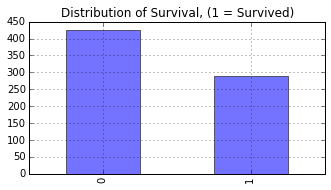

In [14]:
# plot the target variable

# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
#alpha=alpha_scatterplot = 0.2 - not showing any effect
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df_titanic1.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
# ax1.set_xlim(-1, 2)         - not showing any effect
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")

In [ ]:
# plot all features
# understand their distribution - are they categorical or continuous?

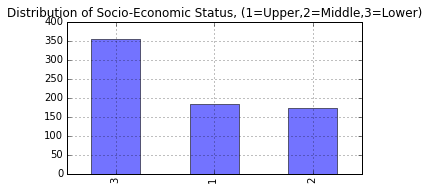

In [15]:
# plot Pclass Feature

# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
#alpha=alpha_scatterplot = 0.2 - not showing any effect
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df_titanic1.Pclass.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
# ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Socio-Economic Status, (1=Upper,2=Middle,3=Lower)")

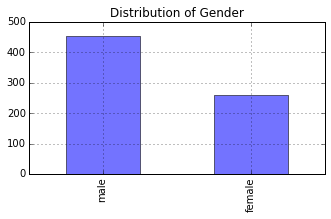

In [16]:
# plot Sex Feature

# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
#alpha=alpha_scatterplot = 0.2 - not showing any effect
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df_titanic1.Sex.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
# ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Gender")

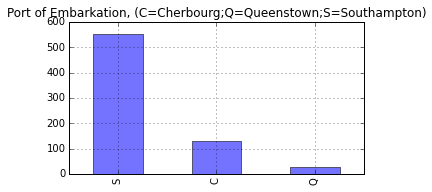

In [17]:
# plot Embarked Feature

# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
#alpha=alpha_scatterplot = 0.2 - not showing any effect
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df_titanic1.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
# ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Port of Embarkation, (C=Cherbourg;Q=Queenstown;S=Southampton)")

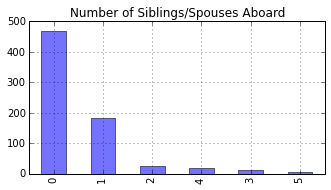

In [18]:
# plot SibSp Feature

# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
#alpha=alpha_scatterplot = 0.2 - not showing any effect
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df_titanic1.SibSp.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
# ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Number of Siblings/Spouses Aboard")

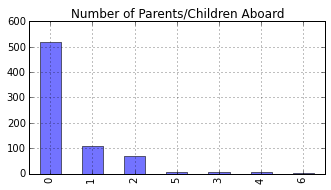

In [19]:
# plot parch Feature

# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
#alpha=alpha_scatterplot = 0.2 - not showing any effect
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df_titanic1.Parch.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
# ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Number of Parents/Children Aboard")

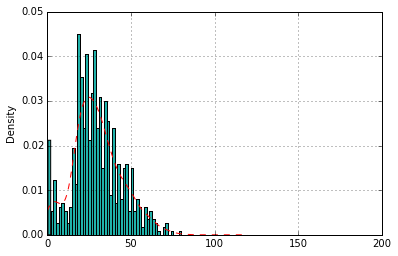

In [52]:
# plot Age Distribution

#histogram
#df_titanic1.Age.hist(grid=True)
#df_titanic1.Age.hist(grid=True, bins=50)

#A density plot is similar to a histogram in that it describes the distribution of the underlying data, but rather than being a pure empirical representation, it is an estimate of the underlying "true" distribution. 
#As a result, it is smoothed into a continuous line plot. 
#We create them in Pandas using the plot method with kind='kde', where kde stands for kernel density estimate.
#df_titanic1.Age.plot(kind='kde', xlim=(0,200))

#Often, histograms and density plots are shown together
df_titanic1.Age.hist(bins=50, normed=True, color='lightseagreen')
df_titanic1.Age.plot(kind='kde', xlim=(0,200), style='r--')

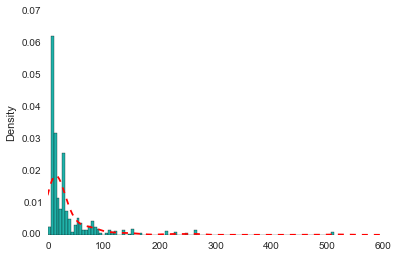

In [15]:
# plot Fare Distribution

#histogram
#df_titanic1.Fare.hist(grid=True)
#df_titanic1.Fare.hist(grid=True, bins=50)

#density plot
#df_titanic1.Fare.plot(kind='kde', xlim=(0,600))

#histogram & density plot
df_titanic1.Fare.hist(bins=100, normed=True, color='lightseagreen')
df_titanic1.Fare.plot(kind='kde', xlim=(0,600), style='r--')

In [33]:
# plot features wrt target variable whereever it makes sense

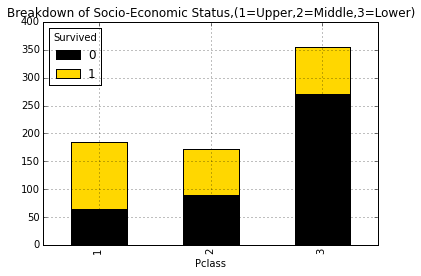

In [20]:
death_counts = pd.crosstab(df_titanic1.Pclass, df_titanic1.Survived)
death_counts.plot(kind='bar', stacked=True, color=['black','gold'], grid=True)
plt.title("Breakdown of Socio-Economic Status,(1=Upper,2=Middle,3=Lower)")

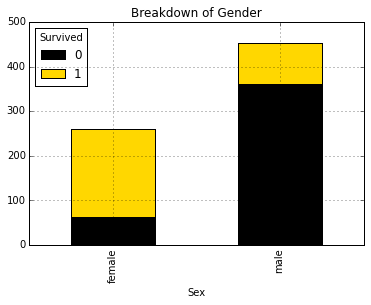

In [21]:
death_counts = pd.crosstab(df_titanic1.Sex, df_titanic1.Survived)
death_counts.plot(kind='bar', stacked=True, color=['black','gold'], grid=True)
plt.title("Breakdown of Gender")

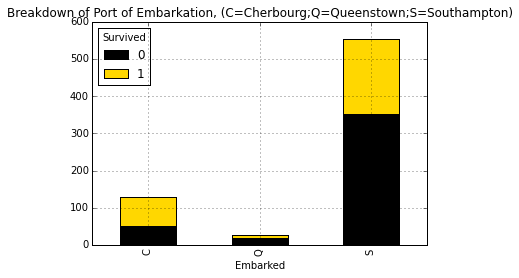

In [22]:
death_counts = pd.crosstab(df_titanic1.Embarked, df_titanic1.Survived)
death_counts.plot(kind='bar', stacked=True, color=['black','gold'], grid=True)
plt.title("Breakdown of Port of Embarkation, (C=Cherbourg;Q=Queenstown;S=Southampton)")

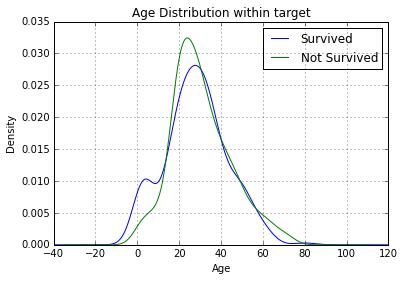

In [60]:
#plt.subplot2grid((2,3),(1,0), colspan=2)
#plots a kernel desnsity estimate of the subset of the 1st class passanges's age
df_titanic1.Age[df_titanic1.Survived == 1].plot(kind='kde')    
df_titanic1.Age[df_titanic1.Survived == 0].plot(kind='kde')
#df_titanic1.Age[df_titanic1.Pclass == 3].plot(kind='kde')

# plots an axis label
plt.xlabel("Age")    
plt.title("Age Distribution within target")
# sets our legend for our graph.
plt.legend(('Survived', 'Not Survived'),loc='best')

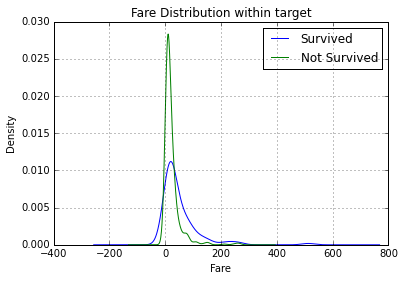

In [62]:
#plt.subplot2grid((2,3),(1,0), colspan=2)
#plots a kernel desnsity estimate of the subset of the 1st class passanges's age
df_titanic1.Fare[df_titanic1.Survived == 1].plot(kind='kde')    
df_titanic1.Fare[df_titanic1.Survived == 0].plot(kind='kde')
#df_titanic1.Age[df_titanic1.Pclass == 3].plot(kind='kde')

# plots an axis label
plt.xlabel("Fare")    
plt.title("Fare Distribution within target")
# sets our legend for our graph.
plt.legend(('Survived', 'Not Survived'),loc='best')

In [ ]:
# additional plots

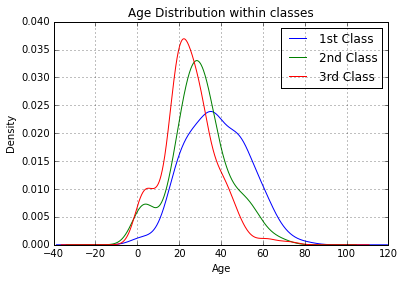

In [59]:
#age and class

#plt.subplot2grid((2,3),(1,0), colspan=2)
#plots a kernel desnsity estimate of the subset of the 1st class passanges's age
df_titanic1.Age[df_titanic1.Pclass == 1].plot(kind='kde')    
df_titanic1.Age[df_titanic1.Pclass == 2].plot(kind='kde')
df_titanic1.Age[df_titanic1.Pclass == 3].plot(kind='kde')

# plots an axis label
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best')

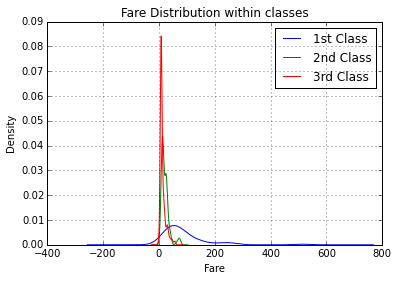

In [66]:
# fare and class

#plt.subplot2grid((2,3),(1,0), colspan=2)
#plots a kernel desnsity estimate of the subset of the 1st class passanges's age
df_titanic1.Fare[df_titanic1.Pclass == 1].plot(kind='kde')    
df_titanic1.Fare[df_titanic1.Pclass == 2].plot(kind='kde')
df_titanic1.Fare[df_titanic1.Pclass == 3].plot(kind='kde')

# plots an axis label
plt.xlabel("Fare")    
plt.title("Fare Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best')

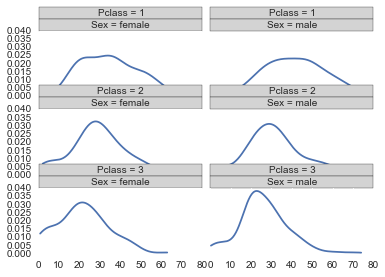

In [7]:
# age, class, sex

from pandas.tools.rplot import *

titanic = df_titanic1[df_titanic1.Age.notnull() & df_titanic1.Fare.notnull()]

tp = RPlot(titanic, x='Age')
tp.add(TrellisGrid(['Pclass', 'Sex']))
tp.add(GeomDensity())
_ = tp.render(plt.gcf())

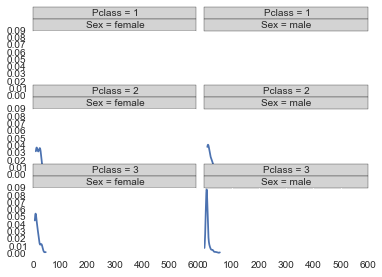

In [9]:
# fare, class, sex

from pandas.tools.rplot import *

titanic = df_titanic1[df_titanic1.Age.notnull() & df_titanic1.Fare.notnull()]

tp = RPlot(titanic, x='Fare')
tp.add(TrellisGrid(['Pclass', 'Sex']))
tp.add(GeomDensity())
_ = tp.render(plt.gcf())

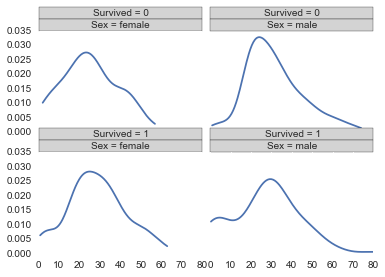

In [8]:
# age, sex and survival

# age, class, sex

from pandas.tools.rplot import *

titanic = df_titanic1[df_titanic1.Age.notnull() & df_titanic1.Fare.notnull()]

tp = RPlot(titanic, x='Age')
tp.add(TrellisGrid(['Survived', 'Sex']))
tp.add(GeomDensity())
_ = tp.render(plt.gcf())

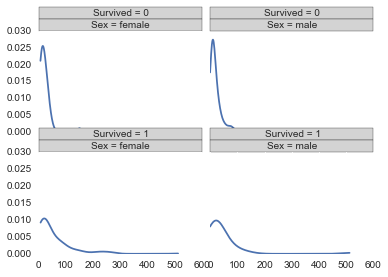

In [10]:
# fare, sex and survival

# age, class, sex

from pandas.tools.rplot import *

titanic = df_titanic1[df_titanic1.Age.notnull() & df_titanic1.Fare.notnull()]

tp = RPlot(titanic, x='Fare')
tp.add(TrellisGrid(['Survived', 'Sex']))
tp.add(GeomDensity())
_ = tp.render(plt.gcf())

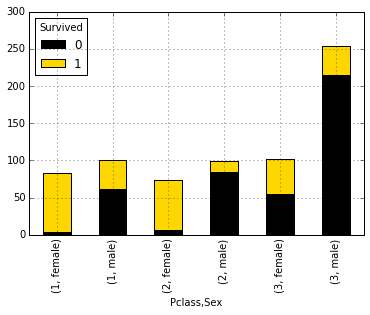

In [23]:
# Class, Sex wrt Survival

death_counts = pd.crosstab([df_titanic1.Pclass, df_titanic1.Sex], df_titanic1.Survived)
death_counts.plot(kind='bar', stacked=True, color=['black','gold'], grid=True)

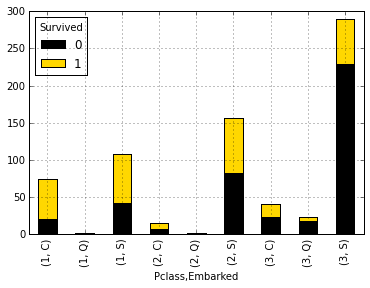

In [63]:
# Class, Embark wrt Survival

death_counts = pd.crosstab([df_titanic1.Pclass, df_titanic1.Embarked], df_titanic1.Survived)
death_counts.plot(kind='bar', stacked=True, color=['black','gold'], grid=True)

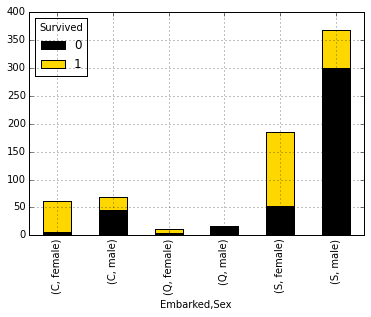

In [64]:
# Embark, Sex wrt Survival

death_counts = pd.crosstab([df_titanic1.Embarked, df_titanic1.Sex], df_titanic1.Survived)
death_counts.plot(kind='bar', stacked=True, color=['black','gold'], grid=True)

In [16]:
# summarize the data
print df_titanic1.describe()

         Survived      Pclass         Age       SibSp       Parch        Fare
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000
mean     0.404494    2.240169   29.642093    0.514045    0.432584   34.567251
std      0.491139    0.836854   14.492933    0.930692    0.854181   52.938648
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    1.000000   20.000000    0.000000    0.000000    8.050000
50%      0.000000    2.000000   28.000000    0.000000    0.000000   15.645850
75%      1.000000    3.000000   38.000000    1.000000    1.000000   33.000000
max      1.000000    3.000000   80.000000    5.000000    6.000000  512.329200


In [17]:
df_titanic1.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.356462,-0.082446,-0.015523,0.095265,0.266100
Pclass,-0.356462,1.000000,-0.365902,0.065187,0.023666,-0.552893
Age,-0.082446,-0.365902,1.000000,-0.307351,-0.187896,0.093143
SibSp,-0.015523,0.065187,-0.307351,1.000000,0.383338,0.139860
Parch,0.095265,0.023666,-0.187896,0.383338,1.000000,0.206624
Fare,0.266100,-0.552893,0.093143,0.139860,0.206624,1.000000


In [12]:
# so far what do we know / hypothesis - 

#1.more females have survived than males
#2.upper class ppl have survived
#3.upper class females have survived more than their counter parts
#4.proportionally ppl who embarked from C=Cherbourg & S=Southampton have survived more than Q=Queenstown
#5.females who embarked from C=Cherbourg & S=Southampton have survived more than males
#6.higher fares could be a good predictor of survival?

#above are just hypothesis but we need to test them in our model!!!!

# Quick Model - What can we learn quickly?

In [11]:
logit1 = sm.logit(formula="Survived ~ C(Pclass) + C(Sex) + Age + SibSp + C(Embarked)", data=df_titanic1).fit()
print logit1.params
print logit1.summary()

Optimization terminated successfully.
         Current function value: 0.444388
         Iterations 6
Intercept           4.542302
C(Pclass)[T.2]     -1.267321
C(Pclass)[T.3]     -2.496643
C(Sex)[T.male]     -2.623913
C(Embarked)[T.Q]   -0.835127
C(Embarked)[T.S]   -0.425414
Age                -0.043636
SibSp              -0.369709
dtype: float64
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Thu, 16 Apr 2015   Pseudo R-squ.:                  0.3414
Time:                        22:29:53   Log-Likelihood:                -316.40
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 5.992e-67
                   

# Data Manipulation

In [18]:
# convert categorical variables into something meaningful

# dummify pclass feature
dummy_ranks = pd.get_dummies(df_titanic1['Pclass'], prefix='SES')
print dummy_ranks.head()

# dummify port feature
dummy_ranks1 = pd.get_dummies(df_titanic1['Embarked'], prefix='Embarked')
print dummy_ranks1.head()

# dummify sex feature
dummy_ranks2 = pd.get_dummies(df_titanic1['Sex'], prefix='Sex')
print dummy_ranks2.head()

   SES_1  SES_2  SES_3
0      0      0      1
1      1      0      0
2      0      0      1
3      1      0      0
4      0      0      1
   Embarked_C  Embarked_Q  Embarked_S
0           0           0           1
1           1           0           0
2           0           0           1
3           0           0           1
4           0           0           1
   Sex_female  Sex_male
0           0         1
1           1         0
2           1         0
3           1         0
4           0         1


In [19]:
# create a clean data frame for the regression

data = df_titanic1.join(dummy_ranks.ix[:, 'SES_1':])    #SES_2 - everything right of this column
data1 = data.join(dummy_ranks1.ix[:, 'Embarked_C':])    #Q&S - everything right of this column
data2 = data1.join(dummy_ranks2.ix[:, 'Sex_female':])   #Males

print data2.head()

   Survived  Pclass     Sex  Age  SibSp  Parch     Fare Embarked  SES_1  \
0         0       3    male   22      1      0   7.2500        S      0   
1         1       1  female   38      1      0  71.2833        C      1   
2         1       3  female   26      0      0   7.9250        S      0   
3         1       1  female   35      1      0  53.1000        S      1   
4         0       3    male   35      0      0   8.0500        S      0   

   SES_2  SES_3  Embarked_C  Embarked_Q  Embarked_S  Sex_female  Sex_male  
0      0      1           0           0           1           0         1  
1      0      0           1           0           0           1         0  
2      0      1           0           0           1           1         0  
3      0      0           0           0           1           1         0  
4      0      1           0           0           1           0         1  


In [20]:
# Remove certain columns
data3 = data2.drop(['Pclass','Sex','Embarked'], axis=1)

# Pre Modeling Analytics

In [14]:
#correlation table wrt to target and w features 

data3.corr()

,Survived,Age,SibSp,Parch,Fare,SES_1,SES_2,SES_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
Survived,1.000000,-0.082446,-0.015523,0.095265,0.266100,0.297908,0.086891,-0.335364,0.195673,-0.048966,-0.159015,0.536762,-0.536762
Age,-0.082446,1.000000,-0.307351,-0.187896,0.093143,0.344976,0.009214,-0.309944,0.038268,-0.021693,-0.025431,-0.099037,0.099037
SibSp,-0.015523,-0.307351,1.000000,0.383338,0.139860,-0.036512,-0.052570,0.077060,-0.046227,0.051331,0.018968,0.106296,-0.106296
Parch,0.095265,-0.187896,0.383338,1.000000,0.206624,-0.013514,-0.018558,0.027750,-0.009523,-0.009417,0.013259,0.249543,-0.249543
Fare,0.266100,0.093143,0.139860,0.206624,1.000000,0.596792,-0.140246,-0.402219,0.301337,-0.062346,-0.250994,0.182457,-0.182457
SES_1,0.297908,0.344976,-0.036512,-0.013514,0.596792,1.000000,-0.334442,-0.588670,0.335545,-0.086426,-0.271535,0.107152,-0.107152
SES_2,0.086891,0.009214,-0.052570,-0.018558,-0.140246,-0.334442,1.000000,-0.564948,-0.140605,-0.080929,0.168577,0.075347,-0.075347
SES_3,-0.335364,-0.309944,0.077060,0.027750,-0.402219,-0.588670,-0.564948,1.000000,-0.173178,0.145087,0.093140,-0.158446,0.158446
Embarked_C,0.195673,0.038268,-0.046227,-0.009523,0.301337,0.335545,-0.140605,-0.173178,1.000000,-0.095623,-0.884986,0.103611,-0.103611
Embarked_Q,-0.048966,-0.021693,0.051331,-0.009417,-0.062346,-0.086426,-0.080929,0.145087,-0.095623,1.000000,-0.378859,0.027256,-0.027256


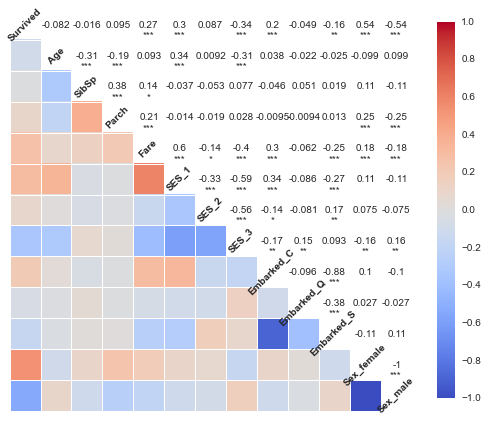

In [15]:
#heatmap using seaborn

f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(data3, ax=ax);

# Modeling

http://statsmodels.sourceforge.net/devel/example_formulas.html

# Model 1 - 5 Terms

In [22]:
logit_5 = sm.logit(formula="Survived ~ Age + SES_1 + SES_2 + Sex_female + SibSp", data=data3).fit()
params_5=logit_5.params
summary_5=logit_5.summary()

print params_5
print summary_5

Optimization terminated successfully.
         Current function value: 0.446657
         Iterations 6
Intercept    -0.938560
Age          -0.044938
SES_1         2.644961
SES_2         1.238679
Sex_female    2.618972
SibSp        -0.378564
dtype: float64
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            5
Date:                Fri, 17 Apr 2015   Pseudo R-squ.:                  0.3381
Time:                        02:11:52   Log-Likelihood:                -318.02
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 4.498e-68
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------

In [47]:
print logit_5.pred_table()
print 'Model Accuracy: {0: 3.0%}'.format(np.diag(logit_5.pred_table()).sum() / logit_5.pred_table().sum())

[[ 364.   60.]
 [  78.  210.]]
Model Accuracy:  81%


# Model 1 - Cross Validation

In [23]:
formula_5 = "Survived ~ Age + SES_1 + SES_2 + Sex_female + SibSp"

Q = np.zeros(data3.shape[0], dtype=np.float64)
y,X = dmatrices(formula_5, data=data3)

for i in range(X.shape[0]):

    ## This is slow, so print progress information
    if i % 100 == 0:  
        print i

    ## The indices of the non held-out cases
    ii = range(X.shape[0])
    ii.remove(i)

    md = Logit(y[ii], X[ii,:])
    mdf = md.fit(disp=False)
    Q[i] = md.predict(mdf.params, exog=X[i,:], linear=True)
    
## Calculate sensitivity and specificity
S = np.linspace(min(Q), max(Q), 100)
Sens = np.zeros(len(S), dtype=np.float64)
Spec = np.zeros(len(S), dtype=np.float64)
i1 = np.flatnonzero(y == 1)
i0 = np.flatnonzero(y == 0)
for i,s in enumerate(S):
    Sens[i] = np.mean(Q[i1] > s)
    Spec[i] = np.mean(Q[i0] <= s)
    
    
## Calculate the AUC using the trapezoidal rule
auc = 0.
for i in range(1,len(Sens)):
    auc += (Spec[i]-Spec[i-1]) * (Sens[i] + Sens[i-1])/2
    
print auc

0
100
200
300
400
500
600
700
0.849994267558


In [24]:
params_5.loc['pseudor2']=0.3381
params_5.loc['auc']=0.849994267558

model_5=params_5
model_5
#if we want to delete dataframe rows
#model_5 = params_5.ix[6:]

Intercept    -0.938560
Age          -0.044938
SES_1         2.644961
SES_2         1.238679
Sex_female    2.618972
SibSp        -0.378564
pseudor2      0.338100
auc           0.849994
dtype: float64

# Model 2 - 6 Terms

In [25]:
logit_6 = sm.logit(formula="Survived ~ Age + Sex_female + SES_1 + SES_2 + SibSp + Age:Sex_female", data=data3).fit()
params_6=logit_6.params
summary_6=logit_6.summary()

print logit_6.params
print logit_6.summary()

Optimization terminated successfully.
         Current function value: 0.438626
         Iterations 6
Intercept        -0.339884
Age              -0.065909
Sex_female        1.228805
SES_1             2.759175
SES_2             1.147179
SibSp            -0.359972
Age:Sex_female    0.050284
dtype: float64
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                            6
Date:                Fri, 17 Apr 2015   Pseudo R-squ.:                  0.3500
Time:                        02:12:05   Log-Likelihood:                -312.30
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 1.345e-69
                     coef    std err          z      P>|z|    

In [46]:
print logit_6.pred_table()
print 'Model Accuracy: {0: 3.0%}'.format(np.diag(logit_6.pred_table()).sum() / logit_6.pred_table().sum())

[[ 360.   64.]
 [  70.  218.]]
Model Accuracy:  81%


# Model 2 - Cross Validation

In [26]:
data3['Age:Sex_female'] = data3['Age']*data3['Sex_female']

formula_6 = "Survived ~ Age + Sex_female + SES_1 + SES_2 + SibSp + Age:Sex_female"

Q = np.zeros(data3.shape[0], dtype=np.float64)
y,X = dmatrices(formula_6, data=data3)

for i in range(X.shape[0]):

    ## This is slow, so print progress information
    if i % 100 == 0:  
        print i

    ## The indices of the non held-out cases
    ii = range(X.shape[0])
    ii.remove(i)

    md = Logit(y[ii], X[ii,:])
    mdf = md.fit(disp=False)
    Q[i] = md.predict(mdf.params, exog=X[i,:], linear=True)
    
## Calculate sensitivity and specificity
S = np.linspace(min(Q), max(Q), 100)
Sens = np.zeros(len(S), dtype=np.float64)
Spec = np.zeros(len(S), dtype=np.float64)
i1 = np.flatnonzero(y == 1)
i0 = np.flatnonzero(y == 0)
for i,s in enumerate(S):
    Sens[i] = np.mean(Q[i1] > s)
    Spec[i] = np.mean(Q[i0] <= s)
    
    
## Calculate the AUC using the trapezoidal rule
auc = 0.
for i in range(1,len(Sens)):
    auc += (Spec[i]-Spec[i-1]) * (Sens[i] + Sens[i-1])/2
print auc

0
100
200
300
400
500
600
700
0.853802247117


In [27]:
params_6.loc['pseudor2']=0.3500
params_6.loc['auc']=0.853802247117

model_6=params_6
model_6
#if we want to delete dataframe rows
#model_5 = params_5.ix[6:]

Intercept        -0.339884
Age              -0.065909
Sex_female        1.228805
SES_1             2.759175
SES_2             1.147179
SibSp            -0.359972
Age:Sex_female    0.050284
pseudor2          0.350000
auc               0.853802
dtype: float64

# Model 3 - 7 Terms

In [28]:
logit_7=sm.logit(formula="Survived ~ Age + Sex_female + SES_1 + SES_2 + SibSp + Age:Sex_female + Age:SES_1", data=data3).fit()
params_7=logit_7.params
summary_7=logit_7.summary()
residuals_7=logit_7.resid_dev

print params_7
print summary_7

Optimization terminated successfully.
         Current function value: 0.434573
         Iterations 7
Intercept         0.182036
Age              -0.088863
Sex_female        0.883415
SES_1             1.305086
SES_2             1.205814
SibSp            -0.405442
Age:Sex_female    0.066556
Age:SES_1         0.046811
dtype: float64
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Fri, 17 Apr 2015   Pseudo R-squ.:                  0.3560
Time:                        02:12:14   Log-Likelihood:                -309.42
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 6.131e-70
                     coef    std er

In [45]:
print logit_7.pred_table()
print 'Model Accuracy: {0: 3.0%}'.format(np.diag(logit_7.pred_table()).sum() / logit_7.pred_table().sum())

[[ 368.   56.]
 [  74.  214.]]
Model Accuracy:  82%


# Model 3 - Cross Validation

In [29]:
data3['Age:Sex_female'] = data3['Age']*data3['Sex_female']
data3['Age:SES_1'] = data3['Age']*data3['SES_1']

formula_7 = "Survived ~ Age + Sex_female + SES_1 + SES_2 + SibSp + Age:Sex_female + Age:SES_1"

## Cross validation
Q = np.zeros(data3.shape[0], dtype=np.float64)
y,X = dmatrices(formula_7, data=data3)

for i in range(X.shape[0]):

    ## This is slow, so print progress information
    if i % 100 == 0:  
        print i

    ## The indices of the non held-out cases
    ii = range(X.shape[0])
    ii.remove(i)

    md = Logit(y[ii], X[ii,:])
    mdf = md.fit(disp=False)
    Q[i] = md.predict(mdf.params, exog=X[i,:], linear=True)

## Calculate sensitivity and specificity
S = np.linspace(min(Q), max(Q), 100)
Sens = np.zeros(len(S), dtype=np.float64)
Spec = np.zeros(len(S), dtype=np.float64)
i1 = np.flatnonzero(y == 1)
i0 = np.flatnonzero(y == 0)
for i,s in enumerate(S):
    Sens[i] = np.mean(Q[i1] > s)
    Spec[i] = np.mean(Q[i0] <= s)

    
## Calculate the AUC using the trapezoidal rule
auc = 0.
for i in range(1,len(Sens)):
    auc += (Spec[i]-Spec[i-1]) * (Sens[i] + Sens[i-1])/2
print auc

0
100
200
300
400
500
600
700
0.858506944444


In [30]:
params_7.loc['pseudor2']=0.3560
params_7.loc['auc']=0.858506944444

model_7=params_7
model_7
#if we want to delete dataframe rows
#model_5 = params_5.ix[6:]

Intercept         0.182036
Age              -0.088863
Sex_female        0.883415
SES_1             1.305086
SES_2             1.205814
SibSp            -0.405442
Age:Sex_female    0.066556
Age:SES_1         0.046811
pseudor2          0.356000
auc               0.858507
dtype: float64

# Model Comparisons & Final Model Selection

In [31]:
# compare the models
model_comparison=DataFrame({'5 Terms' : model_5, '6 Terms' : model_6, '7 Terms' : model_7})

In [32]:
model_comparison

,5 Terms,6 Terms,7 Terms
Age,-0.044938,-0.065909,-0.088863
Age:SES_1,NaN,NaN,0.046811
Age:Sex_female,NaN,0.050284,0.066556
Intercept,-0.938560,-0.339884,0.182036
SES_1,2.644961,2.759175,1.305086
SES_2,1.238679,1.147179,1.205814
Sex_female,2.618972,1.228805,0.883415
SibSp,-0.378564,-0.359972,-0.405442
auc,0.849994,0.853802,0.858507
pseudor2,0.338100,0.350000,0.356000


# Final Model - ROC Curve

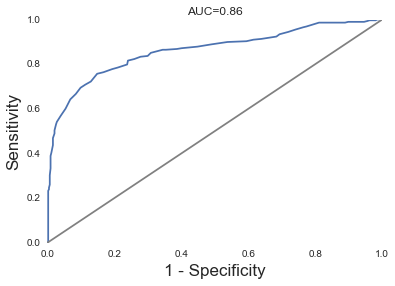

In [33]:
#Plot the ROC curve for the final model selected
#plt.clf()
#plt.grid(True)
plt.plot(1-Spec, Sens, '-')
plt.plot([0,1], [0,1], '-', color='grey')
plt.xlabel("1 - Specificity", size=17)
plt.ylabel("Sensitivity", size=17)
plt.title("AUC=%.2f" % auc)


#plt.plot(1 - Spec, Sens, '-')
#plt.plot([0,1], [0,1], '-', color='grey')
#plt.xlabel("1 - Specificity", size=17)
#plt.ylabel("Sensitivity", size=17)

# Predictions on Training Data

In [86]:
#params_7
#summary_7
#residuals_7

In [34]:
# make predictions on the training dataset
data3['Survived_Predicted'] = logit_7.predict(data3)
training_data=data3.sort(['Survived_Predicted'], ascending=[False])
training_data.head()

,Survived,Age,SibSp,Parch,Fare,SES_1,SES_2,SES_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Age:Sex_female,Age:SES_1,Survived_Predicted
268,1,58,0,1,153.4625,1,0,0,0,0,1,1,0,58,58,0.977942
195,1,58,0,0,146.5208,1,0,0,1,0,0,1,0,58,58,0.977942
11,1,58,0,0,26.5500,1,0,0,0,0,1,1,0,58,58,0.977942
879,1,56,0,1,83.1583,1,0,0,1,0,0,1,0,56,56,0.976860
299,1,50,0,1,247.5208,1,0,0,1,0,0,1,0,50,50,0.973293


In [36]:
training_data['decile'] = pd.qcut(training_data['Survived_Predicted'], 10, labels=np.arange(10, 0, -1))
print training_data.head()
print training_data['decile'].unique()

     Survived  Age  SibSp  Parch      Fare  SES_1  SES_2  SES_3  Embarked_C  \
268         1   58      0      1  153.4625      1      0      0           0   
195         1   58      0      0  146.5208      1      0      0           1   
11          1   58      0      0   26.5500      1      0      0           0   
879         1   56      0      1   83.1583      1      0      0           1   
299         1   50      0      1  247.5208      1      0      0           1   

     Embarked_Q  Embarked_S  Sex_female  Sex_male  Age:Sex_female  Age:SES_1  \
268           0           1           1         0              58         58   
195           0           0           1         0              58         58   
11            0           1           1         0              58         58   
879           0           0           1         0              56         56   
299           0           0           1         0              50         50   

     Survived_Predicted  decile  
268       

In [37]:
decile=training_data.groupby('decile')

In [38]:
decile1=decile['Survived', 'Survived_Predicted']

In [39]:
decile1.agg([np.sum, np.mean, np.min, np.max])

Survived                        Survived_Predicted            \
             sum      mean  amin  amax                 sum      mean   
decile                                                                 
1             70  0.972222     0     1           68.804631  0.955620   
2             66  0.929577     0     1           59.240597  0.834375   
3             50  0.714286     0     1           47.449740  0.677853   
4             33  0.458333     0     1           39.211892  0.544610   
5             22  0.314286     0     1           27.838600  0.397694   
6             12  0.166667     0     1           18.028458  0.250395   
7              7  0.107692     0     1           10.912681  0.167887   
8             12  0.157895     0     1            9.355800  0.123103   
9             12  0.166667     0     1            5.143069  0.071432   
10             4  0.055556     0     1            2.014533  0.027980   

                            
            amin      amax  
decile                      
1       0.926129  0.977942  
2       0.763923  0.924435  
3       0.617244  0.760591  
4       0.472312  0.613765  
5       0.319281  0.469854  
6       0.195053  0.313523  
7       0.145250  0.193664  
8       0.090666  0.145175  
9       0.050807  0.090616  
10      0.001669  0.050778

# Load Test Data

In [48]:
#For Mac OS
Location1 = r'/Users/viral.parikh/Desktop/External_Datasets/kaggle/titanic/test.csv'

test_data = pd.read_csv(Location1)
print test_data.head()
print test_data.info()

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name

In [49]:
# Remove certain columns
test_data = test_data.drop(['Name','Ticket','Cabin'], axis=1)

# Remove NaN values
#test_data = test_data.dropna()

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(2)

In [42]:
# convert categorical variables into something meaningful

# dummify pclass feature
dummy_ranks = pd.get_dummies(test_data['Pclass'], prefix='SES')
print dummy_ranks.head()

# dummify port feature
dummy_ranks1 = pd.get_dummies(test_data['Embarked'], prefix='Embarked')
print dummy_ranks1.head()

# dummify sex feature
dummy_ranks2 = pd.get_dummies(test_data['Sex'], prefix='Sex')
print dummy_ranks2.head()

# create a clean data frame for the regression

test_data = test_data.join(dummy_ranks.ix[:, 'SES_1':])          #SES_2 - everything right of this column
test_data = test_data.join(dummy_ranks1.ix[:, 'Embarked_C':])    #Q&S - everything right of this column
test_data = test_data.join(dummy_ranks2.ix[:, 'Sex_female':])    #Males

test_data['Age:Sex_female'] = test_data['Age']*test_data['Sex_female']
test_data['Age:SES_1'] = test_data['Age']*test_data['SES_1']


print test_data.head()
print test_data.info()

   SES_1  SES_2  SES_3
0      0      0      1
1      0      0      1
2      0      1      0
3      0      0      1
4      0      0      1
   Embarked_C  Embarked_Q  Embarked_S
0           0           1           0
1           0           0           1
2           0           1           0
3           0           0           1
4           0           0           1
   Sex_female  Sex_male
0           0         1
1           1         0
2           0         1
3           0         1
4           1         0
   PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  SES_1  \
0          892       3    male  34.5      0      0   7.8292        Q      0   
1          893       3  female  47.0      1      0   7.0000        S      0   
2          894       2    male  62.0      0      0   9.6875        Q      0   
3          895       3    male  27.0      0      0   8.6625        S      0   
4          896       3  female  22.0      1      1  12.2875        S      0   

   SES_2  SES_3

In [113]:
test_data['Survived_Predicted'] = logit_7.predict(test_data)
test_data_pred=test_data.sort(['Survived_Predicted'], ascending=[False])
test_data_pred.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,SES_1,SES_2,SES_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Age:Sex_female,Age:SES_1,Survived_Predicted
179,1071,1,female,64,0,2,83.1583,C,1,0,0,1,0,0,1,0,64,64,0.980900
48,940,1,female,60,0,0,76.2917,C,1,0,0,1,0,0,1,0,60,60,0.978975
96,988,1,female,76,1,0,78.8500,S,1,0,0,0,0,1,1,0,76,76,0.978698
343,1235,1,female,58,0,1,512.3292,C,1,0,0,1,0,0,1,0,58,58,0.977942
240,1132,1,female,55,0,0,27.7208,C,1,0,0,1,0,0,1,0,55,55,0.976299
